In [1]:
## librerias a importar

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial.distance import cdist,pdist
from scipy.cluster.vq import kmeans



In [5]:
## cargamos los datos

data = pd.read_csv("usuarios_twitter.csv")

data.head()

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


In [6]:
## hacemos una matriz de correlacion para ver que tripleta de caracteristicas utilizamos

feature_list = data[['op', 'co', 'ex', 'ag', 'ne']]

correlation_matrix = feature_list.corr()

correlation_matrix

,op,co,ex,ag,ne
op,1.000000,0.204787,-0.508838,-0.662599,-0.238146
co,0.204787,1.000000,-0.425614,-0.431095,0.180469
ex,-0.508838,-0.425614,1.000000,0.497006,-0.118141
ag,-0.662599,-0.431095,0.497006,1.000000,0.003082
ne,-0.238146,0.180469,-0.118141,0.003082,1.000000


Podemos observar que:

- op esta muy negativamente correlacionada con ag   (-0.66)
- ex esta muy negativamente correlacionada con op y co
- ex esta positivamente correlacionada con ag
- ne tiene baja correlación con el resto de caracteristicas

Para tener variedad en nuestros datos elegiremos las tres caracteristicas co, ex y ne

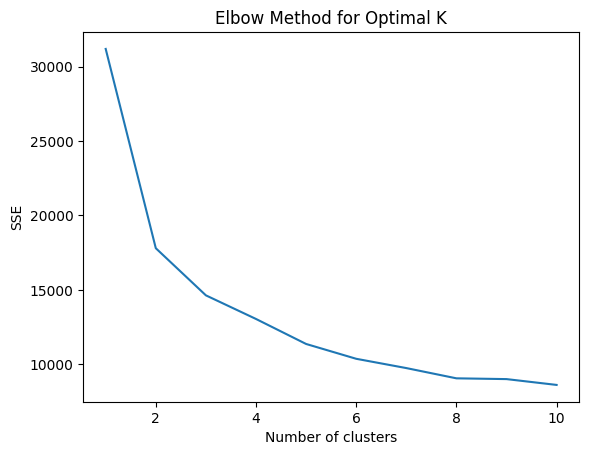

In [7]:
sse = {}  # errores cuadrados sumados
for k in range(1, 11):  # probamos clusters de 1 a 10
    kmeans = KMeans(n_clusters=k, n_init="auto" ,random_state=42).fit(feature_list)
    sse[k] = kmeans.inertia_  # acercamos al cenntroide mas cercano

# mostramos grafica de codo
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title('Elbow Method for Optimal K')
plt.show()

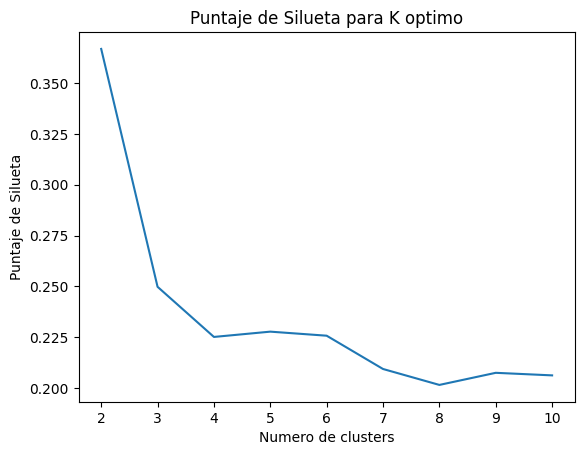

In [8]:
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(feature_list)
    score = silhouette_score(feature_list, kmeans.labels_)
    silhouette_scores[k] = score

# grafico para analisis de silueta
plt.figure()
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
plt.xlabel("Numero de clusters")
plt.ylabel("Puntaje de Silueta")
plt.title('Puntaje de Silueta para K optimo')
plt.show()

Esto nos muestra que el numero de clusters óptimo es el 2, pues es soportado tanto por la formación del codo, como por el puntaje de silueta


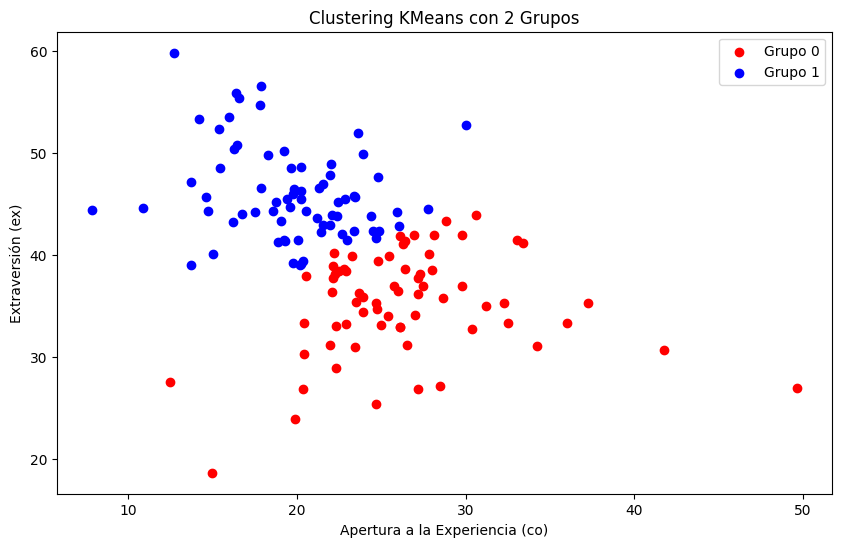

In [10]:
# Seleccionamos solo las características 'co', 'ex' y 'ne'
feature_list = data[['co', 'ex', 'ne']]

# Implementamos el modelo KMeans con 2 clusters
kmeans = KMeans(n_clusters=2,n_init="auto" ,random_state=0)
kmeans.fit(feature_list)

# Realizamos las predicciones para los elementos
predictions = kmeans.predict(feature_list)

# Añadimos las predicciones al DataFrame para poder graficar
data['Cluster'] = predictions

# Graficamos los dos clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue']
for cluster in range(2):
    clustered_data = data[data['Cluster'] == cluster]
    plt.scatter(clustered_data['co'], clustered_data['ex'], c=colors[cluster], label=f'Grupo {cluster}')

plt.title('Clustering KMeans con 2 Grupos')
plt.xlabel('Apertura a la Experiencia (co)')
plt.ylabel('Extraversión (ex)')
plt.legend()
plt.show()

Graficamos en el eje x la apertura a la experiencia y en el eje y la extraversion

- Grupo 0: Puede representar usuarios con puntuaciones más bajas en 'co' y 'ex', posiblemente menos abiertos a la experiencia y menos extrovertidos.

- Grupo 1: Puede representar usuarios con puntuaciones más altas en 'co' y 'ex', indicando ser más abiertos a la experiencia y más extrovertidos.


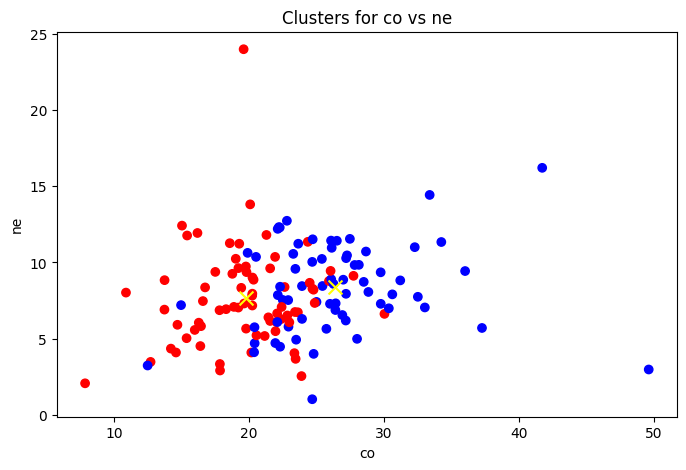

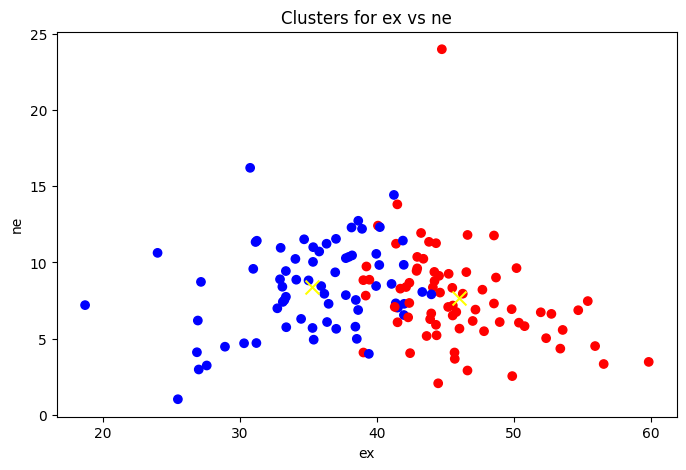

In [11]:
# Para visualizar las otras combinaciones posibles de las características, generaremos gráficos para cada par.

def plot_clusters(data, x_feature, y_feature, cluster_col='Cluster', centroids=None):
    plt.figure(figsize=(8, 5))
    # Utilizamos 'b' para azul y 'r' para rojo en lugar de un cmap
    colors = ['b' if label == 0 else 'r' for label in data[cluster_col]]
    plt.scatter(data[x_feature], data[y_feature], c=colors, marker='o')
    if centroids is not None:
        # Asignamos el color rojo a los centroides
        plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', marker='x', s=100)
    plt.title(f'Clusters for {x_feature} vs {y_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()


# Ahora usaremos esta función para graficar las otras combinaciones de características.
# 'co' vs 'ne'
plot_clusters(data, 'co', 'ne', centroids=kmeans.cluster_centers_[:, [0, 2]])

# 'ex' vs 'ne'
plot_clusters(data, 'ex', 'ne', centroids=kmeans.cluster_centers_[:, [1, 2]])

Grafica1:  Entre mas ordenados mas abiertos a a nuevas experiencias




Grafica2: No se puede interpretar con ese numero de clusters


In [16]:
# Calculando los porcentajes
category_counts = data.groupby(['Cluster', 'categoria']).size().reset_index(name='counts')

total_counts = category_counts.groupby('Cluster')['counts'].transform('sum')
category_counts['percentage'] = category_counts['counts'] / total_counts

# Pivotando la tabla para una mejor visualización
category_table = category_counts.pivot(index='categoria', columns='Cluster', values='percentage')

# Rellenando los valores NaN con 0 para una mejor visualización
category_table = category_table.fillna(0)

# Mostrando la tabla
category_table

Cluster,0,1
categoria,,
1,0.233766,0.142857
2,0.259740,0.222222
3,0.077922,0.047619
4,0.051948,0.238095
5,0.012987,0.047619
6,0.025974,0.095238
7,0.142857,0.095238
8,0.155844,0.063492
9,0.038961,0.047619


Cluster 0: Con una mayor proporción de cantantes, políticos y deportistas, este grupo podría caracterizarse por individuos con niveles más altos de extraversión ('ex'). Estas profesiones a menudo requieren una personalidad más extrovertida, lo que podría explicar la alta presencia de estas categorías en este cluster. Además, la conciencia ('co') podría estar asociada con la disciplina y el compromiso requerido en deportes y política, mientras que un nivel más bajo de neuroticismo ('ne') podría ser beneficioso para manejar el escrutinio público frecuente en estas carreras.

Cluster 1: Con una representación significativa en TV y series, podría sugerir que este grupo contiene una mezcla de personalidades, posiblemente con niveles moderados de 'co', 'ex', y 'ne'. La TV y las series requieren una variedad de roles y personalidades, lo que podría llevar a una distribución más equilibrada de características de personalidad. La presencia más fuerte en tecnología podría indicar un nivel más alto de conciencia ('co') debido a la naturaleza técnica y detallada de esta profesión.